In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import linregress
from tqdm import tqdm
from tqdm.notebook import tqdm
from scipy.stats import linregress
import statsmodels.api as sm
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 300)

In [2]:
#Read in data
data_df = pd.read_csv('/vast/amr10211/inference_partisan_topic_results3.csv')
president_df = pd.read_csv('/vast/amr10211/president_metadata.csv')
people_positions_df = pd.read_csv('/vast/amr10211/people-db-positions-2023-08-31.csv.bz2')

# Ensure that the 'date_filed' column is in datetime format
data_df['date_filed'] = pd.to_datetime(data_df['date_filed'])
president_df['date_start'] = pd.to_datetime( president_df['date_start'])
president_df['date_termination'] = pd.to_datetime( president_df['date_termination'])
data_df['date_start'] = pd.to_datetime( data_df['date_start'])
data_df['date_termination'] = pd.to_datetime( data_df['date_termination'])
data_df = data_df[data_df['imputed_author_str']!="Per Curiam"]

data_df = data_df.rename(columns={'predicted_label':'decision_direction', 'president_id_y':'president_id'})
data_df['opposite_vote'] = (data_df['decision_direction'] != data_df['partisanship']).astype(int)


/state/partition1/job-40796000/ipykernel_1144645/4009057721.py:2: DtypeWarning: Columns (17,19,20,31,34) have mixed types. Specify dtype option on import or set low_memory=False.
  data_df = pd.read_csv('/vast/amr10211/inference_partisan_topic_results3.csv')
/state/partition1/job-40796000/ipykernel_1144645/4009057721.py:4: DtypeWarning: Columns (11,12,13,14,22,23,25) have mixed types. Specify dtype option on import or set low_memory=False.
  people_positions_df = pd.read_csv('/vast/amr10211/people-db-positions-2023-08-31.csv.bz2')


In [4]:
# #Get missing start dates:

# people_positions_df = pd.read_csv('/vast/amr10211/people-db-positions-2023-08-31.csv.bz2')

# new_data_df = data_df
# # Filtering by date if date granularity for start and termination, or year if year granularity (jan 1 date)

# new_data_df =new_data_df.drop(columns=['date_start','date_termination'])

# position_date_df = pd.merge(
#     new_data_df,
#     people_positions_df[['person_id', 'appointer_id', 'date_start', 'date_termination']],
#     how='left',
#     left_on='imputed_person_id',
#     right_on='person_id'
# )
# position_date_df = position_date_df.reset_index(drop=True)
# position_date_df['date_start'] = pd.to_datetime( position_date_df['date_start'])
# position_date_df['date_termination'] = pd.to_datetime( position_date_df['date_termination'], errors='coerce')
# position_date_df = position_date_df[
#     (
#         (
#                     (position_date_df['year_filed'] >= position_date_df['date_start'].dt.year) & 
#                     (position_date_df['year_filed'] <= position_date_df['date_termination'].dt.year)
#         )
#     )
#     | (position_date_df['imputed_person_id'].isnull()) 
#     | (position_date_df['date_start'].isnull()) 
#     | (position_date_df['date_termination'].isnull())
# ]

# # Dropping the temporary 'year_filed' column
# position_date_df = position_date_df.drop(columns=['year_filed'])
# position_date_df = position_date_df[['opinion_id','person_id', 'date_start','date_termination']].drop_duplicates().reset_index(drop=True)

# # #Merge back with original inference_df to get back missing rows
# new_data_df = new_data_df.merge(position_date_df, how='left', on=['opinion_id'])
# new_data_df = new_data_df.drop_duplicates(subset=['opinion_id'], keep='first').reset_index(drop=True) #For any remaining duplicates, keep final record in people_positions_df
# data_df = new_data_df

In [5]:
# def impute_president(row):
#     '''Imputes appointing president based on judge 1start date'''
#     # Check if president_id is not null, if yes, return original values
#     if pd.notnull(row['president_id']):
#         return row['president_id'], row['president_name']
    
#     # If president_id is null, look up in president_df based on date conditions
#     president_match = president_df[
#         (president_df['date_start'] <= row['date_start']) &
#         (row['date_start'] <= president_df['date_termination'])
#     ]
    
#     # If there's a match, return the imputed values
#     if not president_match.empty:
#         return president_match.iloc[0]['president_id'], president_match.iloc[0]['president_name']
    
#     # If no match is found, return null values or any other default values as needed
#     return None, None


In [6]:
# # Merge with president_df to get populated presidents
# data_df = data_df.drop(columns=['president_id', 'president_name', 'partisanship'])
# data_df = data_df.merge(president_df[['president_id', 'president_name', 'partisanship']], how='left', left_on='appointer_id', right_on='president_id')

# print('hi')
# data_df[['imputed_president_id', 'imputed_president_name']] = data_df.apply(impute_president, axis=1, result_type='expand')
# print('hi')

# #Get missing presidents
# data_df = data_df.merge(president_df[['president_id', 'partisanship']], how='left', left_on='imputed_president_id', right_on='president_id')
# print('hi')

# # Fill NaN values in 'partisanship'
# data_df['partisanship'] = data_df['partisanship_y'].fillna(data_df['partisanship_x'])
# print('hi')

# # Drop unnecessary columns
# data_df = data_df.drop(['partisanship_x', 'partisanship_y', 'president_id_x', 'president_id_y'], axis=1)
# print('hi')


# data_df.count()

In [7]:
# imputation_df = data_df.copy()
# print('hi')

# # Identify rows where imputation is needed
# imputation_mask = imputation_df['imputed_president_id'].isnull() & imputation_df['imputed_president_name'].isnull()
# print('hi')

# # Apply the impute_president function only where needed
# imputation_df.loc[imputation_mask, ['imputed_president_id', 'imputed_president_name']] = imputation_df.loc[imputation_mask].apply(impute_president, axis=1, result_type='expand')
# print('hi')

# # Combine the imputed data with the original data
# data_df = pd.concat([data_df, imputation_df[['imputed_president_id', 'imputed_president_name', 'partisanship']]], axis=1)
# print('hi')



In [8]:
# #Get missing presidents
# new_data_df = data_df.loc[:,~data_df.columns.duplicated()].copy()

# new_data_df = new_data_df.merge(president_df[['president_id', 'partisanship']], how='left', left_on='imputed_president_id', right_on='president_id')
# print('hi')

# # Fill NaN values in 'partisanship'
# new_data_df['partisanship'] = new_data_df['partisanship_y'].fillna(new_data_df['partisanship_x'])
# print('hi')

# # Drop unnecessary columns
# new_data_df = new_data_df.drop(['partisanship_x', 'partisanship_y', 'president_id_x', 'president_id_y'], axis=1)
# print('hi')

In [10]:
# data_df=new_data_df

In [3]:
data_df.count()

Unnamed: 0.2              3465502
Unnamed: 0.1              3465502
Unnamed: 0                3465502
resource_uri                    0
opinion_id                3465502
absolute_url                    0
cluster_id                3465502
cluster                         0
author_id                 1107788
author                          0
joined_by                       0
date_created              3465502
date_modified             3465502
author_str                2631440
per_curiam                3465502
joined_by_str                   0
type                      3465502
sha1                      1811026
page_count                 263991
download_url               410544
local_path                 504192
extracted_by_ocr          3465502
opinions_cited                  0
judges                    3465382
judge                     3465502
date_filed                3465502
token_count               3465502
decision_direction        3465502
probability               3465502
docket_id     

## Averages by President

In [7]:
#Format for visual
president_visualization_df = data_df[['opinion_id','date_filed','unique_person_id', 'imputed_author_str', 'imputed_court_id', 'date_start', 'date_termination', 'probability', 'decision_direction','president_name', 'imputed_president_id', 'imputed_president_name', 'partisanship']]
president_visualization_df['year_filed'] = president_visualization_df['date_filed'].dt.year
president_visualization_df['year_start'] = president_visualization_df['date_start'].dt.year
president_visualization_df['year_termination'] = president_visualization_df['date_termination'].dt.year
president_visualization_df['years_since_first_case'] = president_visualization_df['year_filed'] - president_visualization_df['year_start']
president_visualization_df = president_visualization_df[president_visualization_df['years_since_first_case']>=0]
president_visualization_df = president_visualization_df[president_visualization_df['years_since_first_case']<=40]


#filter for appointing presidents >1930 (FDR and up)
president_visualization_df = president_visualization_df[president_visualization_df['imputed_president_id']>=31]

/state/partition1/job-40741321/ipykernel_3855459/1499273340.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  president_visualization_df['year_filed'] = president_visualization_df['date_filed'].dt.year
/state/partition1/job-40741321/ipykernel_3855459/1499273340.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  president_visualization_df['year_start'] = president_visualization_df['date_start'].dt.year
/state/partition1/job-40741321/ipykernel_3855459/1499273340.py:5: SettingWithCopyWarning: 
A value is tr

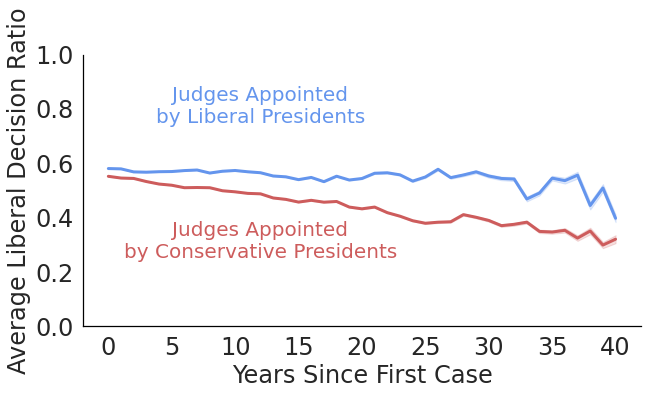

In [26]:
# filtered_df = president_visualization_df.dropna(subset=['partisanship'])
# filtered_df = filtered_df[filtered_df['year_filed']<=2020]

# # Filter data for liberal and conservative presidents
# liberal_df = filtered_df[filtered_df['partisanship'] == 0 ]
# conservative_df = filtered_df[filtered_df['partisanship'] == 1 ]

# # Calculate the proportion of conservative decisions for each judge at each point in time
# liberal_df['liberal_decision_ratio'] = liberal_df.groupby(['unique_person_id', 'years_since_first_case'])['decision_direction'].transform(lambda x: x.eq(0).cumsum() / x.notna().cumsum())
# conservative_df['liberal_decision_ratio'] = conservative_df.groupby(['unique_person_id', 'years_since_first_case'])['decision_direction'].transform(lambda x: x.eq(0).cumsum() / x.notna().cumsum())

# Plotting the liberal presidents' data
plt.figure(figsize=(10, 5))
sns.lineplot(x='years_since_first_case', y='liberal_decision_ratio', data=liberal_df, color='cornflowerblue', estimator='mean', errorbar='se', lw=3)
# plt.title('Average Liberal Percentage Across All Justices Over Years Since First Case (Liberal Presidents)', fontsize=24)
plt.xlabel('Years Since First Case', fontsize=18)
# plt.ylabel('Average Liberal Percentage', fontsize=24)
# plt.legend(fontsize=18)
sns.despine()
# plt.show()

# Plotting the conservative presidents' data
sns.lineplot(x='years_since_first_case', y='liberal_decision_ratio', data=conservative_df, color='indianred', estimator='mean', errorbar='se', lw=3)
# plt.title('Average Liberal Percentage Across All Justices Over Years Since First Case (Conservative Presidents)', fontsize=24)
plt.xlabel('Years Since First Case', fontsize=24)
plt.ylabel('Average Liberal Decision Ratio', fontsize=24)
plt.text(12, 0.75, 'Judges Appointed\nby Liberal Presidents', color='cornflowerblue', fontsize=20,  ha='center')
plt.text(12, .25, 'Judges Appointed\nby Conservative Presidents', color='indianred', fontsize=20, ha='center')
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.ylim(0,1)
# plt.legend(fontsize=24)
sns.despine()
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

plt.show()


## Likelihood of Judges Siding with Opposite of Appointing President over Time

In [14]:
#Format Data
judge_partisan_switch_visualization_df = data_df[['opinion_id','date_filed','unique_person_id', 'imputed_author_str', 'imputed_court_id', 'decision_direction', 'probability', 'opposite_vote', 'imputed_president_id', 'date_start', 'date_termination', 'imputed_president_name', 'partisanship']]
judge_partisan_switch_visualization_df['year_filed'] = judge_partisan_switch_visualization_df['date_filed'].dt.year



/state/partition1/job-40741321/ipykernel_3855459/1433758598.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  judge_partisan_switch_visualization_df['year_filed'] = judge_partisan_switch_visualization_df['date_filed'].dt.year


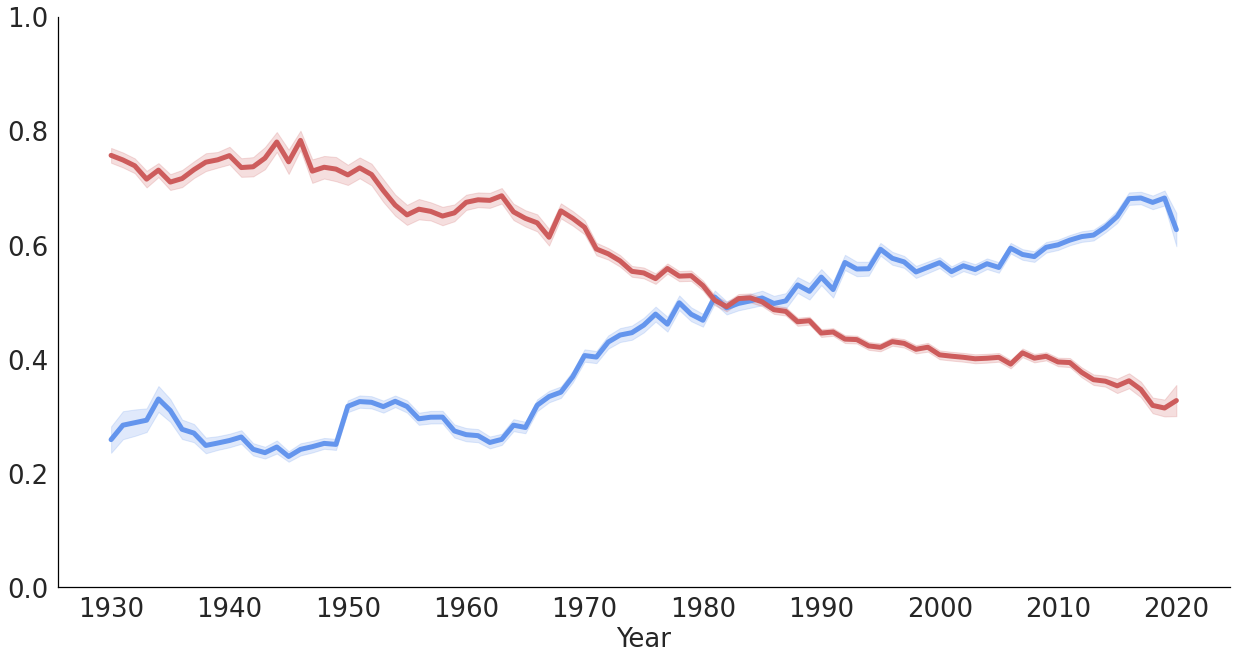

In [15]:
#BREAK DOWN BY PARTY
# Filter out rows where partisanship is NaN
filtered_df = judge_partisan_switch_visualization_df.dropna(subset=['partisanship'])
# filtered_df = filtered_df[filtered_df['probability']>0.7]
filtered_df = filtered_df[filtered_df['year_filed']<=2020]

# Calculate the percentage of opposite votes for each judge within each year
judge_opposite_vote_percentage = (
    filtered_df.groupby(['year_filed', 'unique_person_id', 'partisanship'])['opposite_vote']
    .mean()  # calculates the mean, which gives the percentage because 1 is opposite and 0 is the same
    .reset_index()
)


# Set the style for the plot
sns.set(style="white", font_scale=1.5)

# Create a figure and axis with specified size
plt.figure(figsize=(21, 10.5))

# Plotting with improved formatting
sns.lineplot(x='year_filed', y='opposite_vote', data=judge_opposite_vote_percentage, hue='partisanship', palette={0: 'cornflowerblue', 1: 'indianred'}, errorbar='se', linewidth=5, legend=False)


# Title and labels with increased font size
# plt.title('Likelihood of Judge Casting Opposite Partisanship Vote Over Time', fontsize=24)
plt.xlabel('Year', fontsize=26)
# plt.ylabel('Percentage of Decisions with \nOpposite Partianship \nof Appointing President', fontsize=24)
plt.ylabel(None)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.xticks(range(1930, 2021, 10))  # Adjust the range according to your data

# Set y-axis limit between 0 and 1 for percentage

# Remove grid lines
sns.despine()
plt.ylim(0,1)

ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

plt.show()


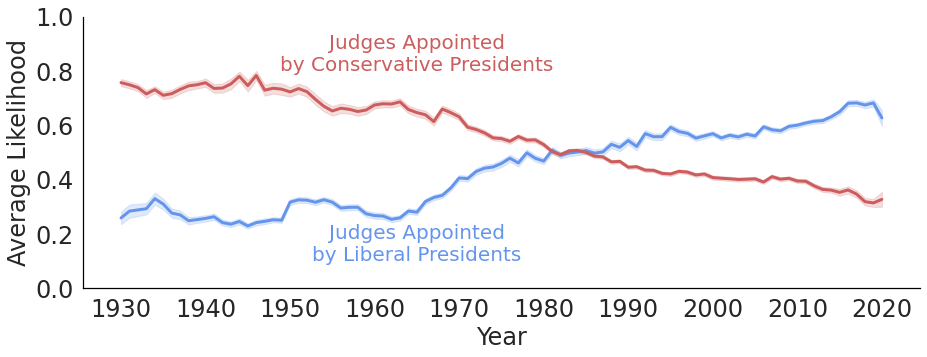

In [25]:
#BREAK DOWN BY PARTY
# Filter out rows where partisanship is NaN
filtered_df = judge_partisan_switch_visualization_df.dropna(subset=['partisanship'])
# filtered_df = filtered_df[filtered_df['probability']>0.7]
filtered_df = filtered_df[filtered_df['year_filed']<=2020]

# Calculate the percentage of opposite votes for each judge within each year
judge_opposite_vote_percentage = (
    filtered_df.groupby(['year_filed', 'unique_person_id', 'partisanship'])['opposite_vote']
    .mean()  # calculates the mean, which gives the percentage because 1 is opposite and 0 is the same
    .reset_index()
)


# Set the style for the plot
sns.set(style="white", font_scale=1.5)

# Create a figure and axis with specified size
plt.figure(figsize=(15, 5))

# Plotting with improved formatting
sns.lineplot(x='year_filed', y='opposite_vote', data=judge_opposite_vote_percentage, hue='partisanship', palette={0: 'cornflowerblue', 1: 'indianred'}, errorbar='se', linewidth=3, legend=False)


# Title and labels with increased font size
# plt.title('Likelihood of Judge Casting Opposite Partisanship Vote Over Time', fontsize=24)
plt.xlabel('Year', fontsize=24)
plt.ylabel('Average Likelihood', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xticks(range(1930, 2021, 10))  # Adjust the range according to your data
plt.text(1965, 0.1, 'Judges Appointed\nby Liberal Presidents', color='cornflowerblue', fontsize=20,  ha='center')
plt.text(1965, .8, 'Judges Appointed\nby Conservative Presidents', color='indianred', fontsize=20, ha='center')

# Set y-axis limit between 0 and 1 for percentage

# Remove grid lines
sns.despine()
plt.ylim(0,1)

ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

plt.show()


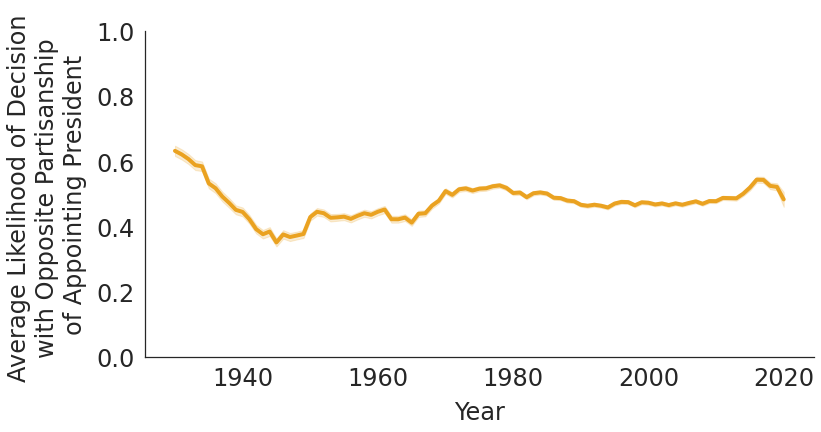

In [28]:
# Filter out rows where partisanship is NaN
filtered_df = judge_partisan_switch_visualization_df.dropna(subset=['partisanship'])
# filtered_df = filtered_df[filtered_df['probability']>0.7]
filtered_df = filtered_df[filtered_df['year_filed']<=2020]

# Calculate the percentage of opposite votes for each judge within each year
judge_opposite_vote_percentage = (
    filtered_df.groupby(['year_filed', 'unique_person_id'])['opposite_vote']
    .mean()  # calculates the mean, which gives the percentage because 1 is opposite and 0 is the same
    .reset_index()
)


# Set the style for the plot
sns.set(style="white", font_scale=1.5)

# Create a figure and axis with specified size
plt.figure(figsize=(12, 6))


# Plotting with improved formatting
sns.lineplot(x='year_filed', y='opposite_vote', data=judge_opposite_vote_percentage, color = '#EAA221', errorbar='se', linewidth=4, legend=False)

# Title and labels with increased font size
# plt.title('Likelihood of Judge Casting Opposite Partisanship Vote Over Time', fontsize=24)
plt.xlabel('Year', fontsize=24)
plt.ylabel('Average Likelihood of Decision \nwith Opposite Partisanship \nof Appointing President', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

# Set y-axis limit between 0 and 1 for percentage

# Remove grid lines
sns.despine()
plt.ylim(0,1)

# Show the plot
plt.show()


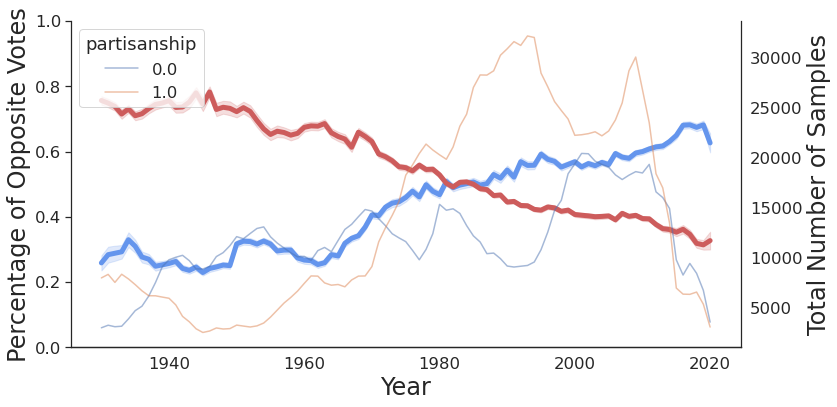

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have already defined and processed your DataFrame as 'filtered_df'
filtered_df = filtered_df[filtered_df['imputed_author_str']!="Per Curiam"]

# Calculate the total number of samples for each year
total_samples_per_year = filtered_df.groupby(['year_filed', 'partisanship'])['unique_person_id'].count().reset_index()

# Calculate the percentage of opposite votes for each judge within each year
judge_opposite_vote_percentage = (
    filtered_df.groupby(['year_filed', 'unique_person_id', 'partisanship'])['opposite_vote']
    .mean()
    .reset_index()
)

# Set the style for the plot
sns.set(style="white", font_scale=1.5)

# Create a figure and axis with specified size
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting the percentage of opposite votes
sns.lineplot(x='year_filed', y='opposite_vote', data=judge_opposite_vote_percentage,
             hue='partisanship', palette={0: 'cornflowerblue', 1: 'indianred'},
             errorbar='se', linewidth=5, legend=False, ax=ax1)

# Creating a secondary y-axis for the total number of samples
ax2 = ax1.twinx()
sns.lineplot(x='year_filed', y='unique_person_id', data=total_samples_per_year, hue = 'partisanship',
            color='lightgrey', ax=ax2, alpha=0.5)

# Title and labels with increased font size
ax1.set_xlabel('Year', fontsize=24)
ax1.set_ylabel('Percentage of Opposite Votes', fontsize=24)
ax2.set_ylabel('Total Number of Samples', fontsize=24)

# Set y-axis limit between 0 and 1 for the percentage plot
ax1.set_ylim(0, 1)

# Remove grid lines for both axes
sns.despine(ax=ax1, right=True, left=False)
sns.despine(ax=ax2, left=True, right=False)

# Show the plot
plt.show()


## Topic Share Over Time

In [3]:
#Format Data
topic_visualization_df = data_df[['opinion_id','date_filed','unique_person_id', 'imputed_author_str', 'imputed_court_id', 'decision_direction','opposite_vote', 'imputed_president_id', 'imputed_president_name', 'partisanship', 'predicted_topic_label']]
topic_visualization_df['year_filed'] = topic_visualization_df['date_filed'].dt.year


/state/partition1/job-40796000/ipykernel_1144645/3850054826.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_visualization_df['year_filed'] = topic_visualization_df['date_filed'].dt.year


<Figure size 1008x1008 with 0 Axes>

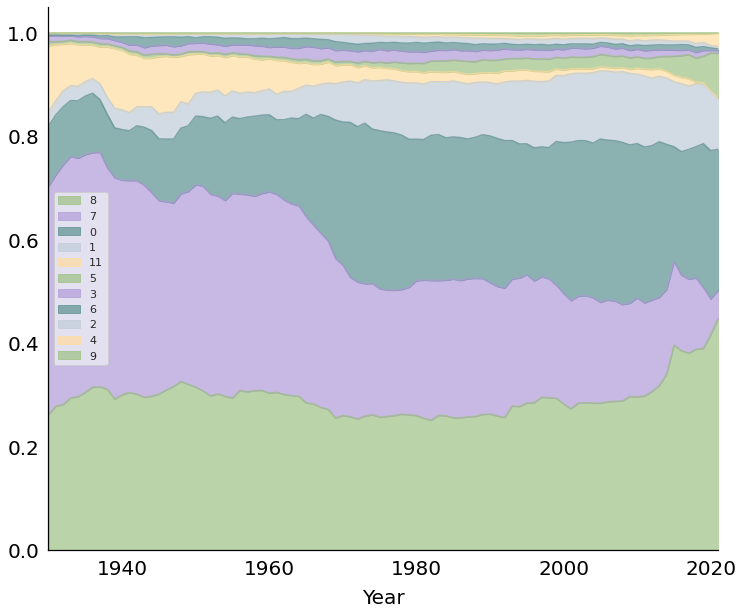

In [4]:
# 0 Criminal Procedure
# 1 Civil Rights

# 2 First Amendment

# 3 Due Process

# 4 Privacy

# 5 Attorneys

# 6 Unions

# 7 Economic Activity

# 8 Judicial Power

# 9 Federalism

# 10 Interstate Relations

# 11Federal Taxation

# 12 Miscellaneous

# 13 Private Action


# Assuming you have the necessary data, calculate the counts per year and pivot the table
topic_counts_per_year = topic_visualization_df.groupby(['year_filed', 'predicted_topic_label']).size().reset_index(name='count')
topic_counts_per_year_pivot = topic_counts_per_year.pivot(index='year_filed', columns='predicted_topic_label', values='count').fillna(0)

# Calculate the sum of occurrences for each topic
topic_sums = topic_counts_per_year_pivot.sum(axis=0)

# Sort topics by sum in descending order and get the top 5 topics
top_topics = topic_sums.sort_values(ascending=False).head(13).index
topic_counts_top5_pivot = topic_counts_per_year_pivot[top_topics]

# Calculate the share of top 5 topics per year
topic_share_top5 = topic_counts_top5_pivot.div(topic_counts_top5_pivot.sum(axis=1), axis=0)

# Create a larger stacked area plot for the top 5 topics
sns.set(rc={'figure.figsize': (12, 10), 'axes.labelpad': 10})

# Create an array with the colors you want to use
# colors = ['#849DB1', '#92A875', '#D98C8C', '#A5A5A5', "#5C9090"]
colors = ['#9dc183', '#b19cd9', '#5C9090', '#bfcdd8', "#ffdda1"]

plt.figure(figsize=(14, 14))

# Plot the stacked area chart with custom colors
ax = topic_share_top5.plot(kind='area', stacked=True, alpha=0.7, color=colors) #, legend=None)

# Set background color to transparent
ax.set_facecolor('none')

# Remove grid lines
ax.xaxis.grid(False)
ax.yaxis.grid(False)
sns.despine()

# Set text size
plt.xticks(fontsize=20, color='black')
plt.yticks(fontsize=20, color='black')
# plt.title('Share of Top 5 Predicted Topic Labels Over Time', fontsize=24)
plt.xlabel('Year', fontsize=20, color='black')
# plt.xticks(range(1930, 2021, 20))  # Adjust the range according to your data

# Annotate the plot with topic labels
# topic_labels = ['Judicial Power', 'Economic Activity', 'Criminal Procedure', 'Civil Rights', 'Federal Taxation']
# label_positions = [(1940, 0.55), (1940, 0.75), (1940, 0.1), (1940, 0.02), (1940, 0.65)]

# for label, (x, y) in zip(topic_labels, label_positions):
#     plt.annotate(label, xy=(x, y), fontsize=16, ha='left', va='center')
sns.despine()
plt.legend()
plt.xlim(1930,2021)
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

plt.show()


#orange ff8b3d , pink '#D98C8C', green (9dc183), grey (a7afb2), marigold (eaa221)





/state/partition1/job-40796000/ipykernel_1144645/4175156497.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_visualization_df['topic'] = topic_visualization_df['predicted_topic_label'].map(label_mapping)


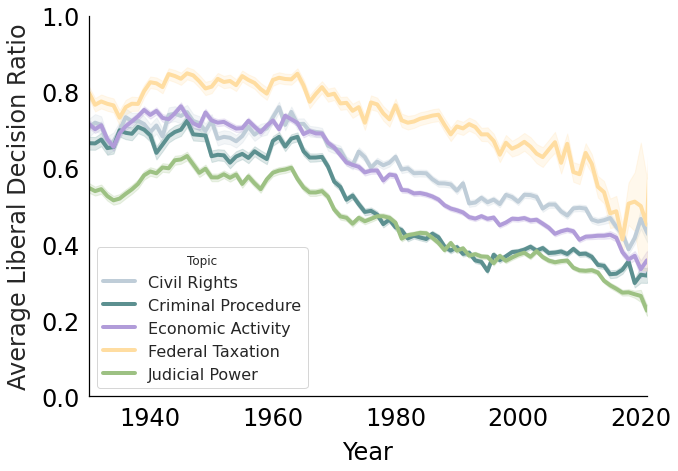

In [6]:
label_mapping = {
    0: 'Criminal Procedure',
    1: 'Civil Rights',
    2: 'First Amendment',
    3: 'Due Process',
    4: 'Privacy',
    5: 'Attorneys',
    6: 'Unions',
    7: 'Economic Activity',
    8: 'Judicial Power',
    9: 'Federalism',
    10: 'Interstate Relations',
    11: 'Federal Taxation',
    12: 'Miscellaneous',
    13: 'Private Action'
}

# #ffdda1:

# This is a light, warm color with a hexadecimal representation of a pale yellow or beige tone. It has a mix of red, green, and blue, with higher values in the red component.
# #b19cd9:

# This color has a bluish-purple hue, falling into the lavender or periwinkle spectrum. It is a muted, soft shade with a combination of blue and purple tones.
# #bfcdd8:

# This color is a light, desaturated blue-gray. It has a cool and calming appearance, often associated with tranquil or serene environments.
# #5C9090:

# This is a medium to dark shade of teal or turquoise. It has a balanced mix of green and blue, creating a color reminiscent of ocean waters.
# #9dc183:

# This color is a muted, earthy green with a slight yellow undertone. It can be described as an olive or moss green, conveying a natural and organic feel.
# #5C9090:

# This color is repeated in your list. It is the same as the fourth color described above, a medium to dark shade of teal or turquoise.


colors = ['#bfcdd8',     '#5C9090','#b19cd9',"#ffdda1",'#9dc183']


# Add a new column 'topic_label' based on the mapping
topic_visualization_df['topic'] = topic_visualization_df['predicted_topic_label'].map(label_mapping)

# Get the top 3 topics based on count
top_topics = topic_visualization_df['topic'].value_counts().nlargest(5).index

# Filter the DataFrame for the top 3 topics
top_topics_df = topic_visualization_df[topic_visualization_df['topic'].isin(top_topics)]

# Group by 'year_filed', 'topic_label', and 'decision_direction', then count occurrences
topic_decision_counts_per_year = top_topics_df.groupby(['year_filed', 'topic', 'unique_person_id', 'decision_direction']).size().reset_index(name='decision_count')

# Pivot the DataFrame to have 'topic_label' and 'decision_direction' as columns
decision_counts_pivot = topic_decision_counts_per_year.pivot_table(index=['year_filed', 'topic','unique_person_id'], columns='decision_direction', values='decision_count', fill_value=0).reset_index()

# Calculate the liberal ratio for each topic
decision_counts_pivot['liberal_ratio'] = decision_counts_pivot[0] / (decision_counts_pivot[0] + decision_counts_pivot[1])

# Create line plots for each topic with darker colors
plt.figure(figsize=(10, 7))
sns.set(style="whitegrid")
sns.lineplot(data=decision_counts_pivot, x='year_filed', y='liberal_ratio', hue='topic', palette=colors, linewidth=4, errorbar='se')
# plt.title('Liberal Ratio of Top 3 Topics Over Time', size=24)
plt.xlabel('Year', size=24, color='black')
plt.ylabel('Average Liberal Decision Ratio', size=24)
plt.xticks(size=24, color='black')
plt.yticks(size=24, color='black')
plt.legend(title='Topic', loc='lower left', prop={'size': 16})
ax.grid(False)
plt.gca().grid(False)
plt.ylim(0,1)
plt.xlim(1930,2021)

sns.despine()

plt.xlim(1930,2021)
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

plt.show()




In [34]:
decision_counts_pivot

decision_direction,year_filed,topic_label,unique_person_id,partisanship,0,1,liberal_ratio
0,1930,Judicial Power,1006,1.0,1,0,1.000000
1,1930,Judicial Power,1028,1.0,2,1,0.666667
2,1930,Judicial Power,110,1.0,0,1,0.000000
3,1930,Judicial Power,1100,1.0,5,1,0.833333
4,1930,Judicial Power,1143,0.0,1,4,0.200000
...,...,...,...,...,...,...,...
102441,2023,Judicial Power,9701,0.0,0,1,0.000000
102442,2023,Judicial Power,9702,0.0,0,2,0.000000
102443,2023,Judicial Power,9703,1.0,1,0,1.000000
102444,2023,Judicial Power,9707,0.0,0,2,0.000000


In [43]:
topic_visualization_df['topic_label'].value_counts().nlargest(2).index.tolist()[1:]

['Economic Activity']

/state/partition1/job-40741321/ipykernel_3855459/3693285141.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_visualization_df['topic_label'] = topic_visualization_df['predicted_topic_label'].map(label_mapping)


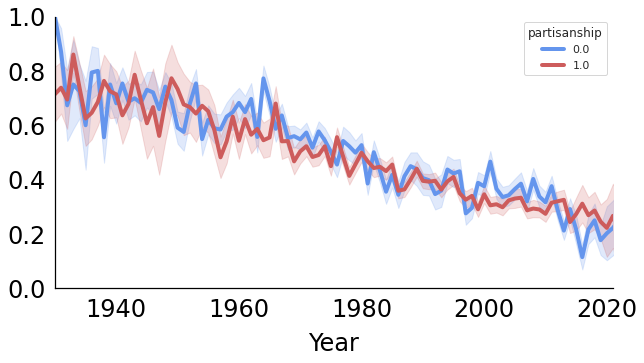

In [51]:
label_mapping = {
    0: 'Criminal Procedure',
    1: 'Civil Rights',
    2: 'First Amendment',
    3: 'Due Process',
    4: 'Privacy',
    5: 'Attorneys',
    6: 'Unions',
    7: 'Economic Activity',
    8: 'Judicial Power',
    9: 'Federalism',
    10: 'Interstate Relations',
    11: 'Federal Taxation',
    12: 'Miscellaneous',
    13: 'Private Action'
}
# colors = ['#9dc183', '#b19cd9', '#5C9090', '#bfcdd8', "#ffdda1"]
colors =['cornflowerblue','indianred']

# Add a new column 'topic_label' based on the mapping
topic_visualization_df['topic_label'] = topic_visualization_df['predicted_topic_label'].map(label_mapping)

# Get the top 3 topics based on count
top_topics = topic_visualization_df['topic_label'].value_counts().nlargest(9).index.tolist()[8:]

# Filter the DataFrame for the top 3 topics
top_topics_df = topic_visualization_df[topic_visualization_df['topic_label'].isin(top_topics)]

# Group by 'year_filed', 'topic_label', and 'decision_direction', then count occurrences
topic_decision_counts_per_year = top_topics_df.groupby(['year_filed', 'topic_label', 'unique_person_id', 'decision_direction', 'partisanship']).size().reset_index(name='decision_count')

# Pivot the DataFrame to have 'topic_label' and 'decision_direction' as columns
decision_counts_pivot = topic_decision_counts_per_year.pivot_table(index=['year_filed', 'topic_label','unique_person_id', 'partisanship'], columns='decision_direction', values='decision_count', fill_value=0).reset_index()

# Calculate the liberal ratio for each topic
decision_counts_pivot['liberal_ratio'] = decision_counts_pivot[0] / (decision_counts_pivot[0] + decision_counts_pivot[1])

# Create line plots for each topic with darker colors
plt.figure(figsize=(10, 5))
sns.set(style="whitegrid")
sns.lineplot(data=decision_counts_pivot, x='year_filed', y='liberal_ratio', hue='partisanship', palette=colors, linewidth=4, errorbar='se')
# plt.title('Liberal Ratio of Top 3 Topics Over Time', size=24)
plt.xlabel('Year', size=24, color='black')
plt.ylabel('Average Liberal Decision Ratio', size=24)
plt.ylabel(None)
plt.xticks(size=24, color='black')
plt.yticks(size=24, color='black')
# plt.legend(title='Topic Label', bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 16})
ax.grid(False)
plt.gca().grid(False)
plt.ylim(0,1)
plt.xlim(1930,2021)

sns.despine()

plt.xlim(1930,2021)
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

plt.show()


## Top Judge Partisan Movement

In [37]:
#Format for visual
visualization_df = data_df[['opinion_id','date_filed','unique_person_id', 'imputed_author_str', 'imputed_court_id', 'decision_direction']]
visualization_df['year_filed'] = visualization_df['date_filed'].dt.year

/state/partition1/job-40734034/ipykernel_560499/4221531913.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visualization_df['year_filed'] = visualization_df['date_filed'].dt.year


### Conservative Slope

In [7]:
# # Ensure that the 'date_filed' column is in datetime format
# visualization_df['date_filed'] = pd.to_datetime(visualization_df['date_filed'])

# # Sort the DataFrame by 'unique_person_id' and 'date_filed'
# visualization_df.sort_values(by=['unique_person_id', 'date_filed'], inplace=True)

# # Calculate the proportion of conservative decisions for each judge at each point in time
# visualization_df['conservative_decision_ratio'] = visualization_df.groupby('unique_person_id')['decision_direction'].transform(lambda x: x.eq(1).cumsum() / x.notna().cumsum())

# # Calculate the proportion of liberal decisions for each judge at each point in time
# visualization_df['liberal_decision_ratio'] = visualization_df.groupby('unique_person_id')['decision_direction'].transform(lambda x: x.eq(0).cumsum() / x.notna().cumsum())

# # Fit a linear regression line for each judge and extract the slope for conservative decisions
# judge_slopes_conservative = []
# for judge_id, data in visualization_df.groupby('unique_person_id'):
#     timestamps = data['year_filed']
    
#     # Check if there is enough variability in timestamps
#     if timestamps.nunique() > 1:
#         slope, intercept, r_value, p_value, std_err = linregress(timestamps, data['conservative_decision_ratio'])
#         judge_slopes_conservative.append({'judge_id': judge_id, 'slope': slope})

# # Fit a linear regression line for each judge and extract the slope for liberal decisions
# judge_slopes_liberal = []
# for judge_id, data in visualization_df.groupby('unique_person_id'):
#     timestamps = data['year_filed']
    
#     # Check if there is enough variability in timestamps
#     if timestamps.nunique() > 1:
#         slope, intercept, r_value, p_value, std_err = linregress(timestamps, data['liberal_decision_ratio'])
#         judge_slopes_liberal.append({'judge_id': judge_id, 'slope': slope})

# # Create DataFrames with judge slopes for conservative and liberal decisions
# judge_slopes_conservative_df = pd.DataFrame(judge_slopes_conservative)
# judge_slopes_liberal_df = pd.DataFrame(judge_slopes_liberal)

# # Plot the distribution of slopes for conservative decisions
# sns.histplot(judge_slopes_conservative_df['slope'], kde=True, label='Conservative')
# # Plot the distribution of slopes for liberal decisions
# sns.histplot(judge_slopes_liberal_df['slope'], kde=True, label='Liberal')

# plt.title('Distribution of Judge Slopes for Conservative and Liberal Decisions')
# plt.xlabel('Slope of Decision Ratio Over Time')
# plt.ylabel('Frequency')
# plt.legend()
# plt.show()


In [47]:
# Ensure that the 'date_filed' column is in datetime format
visualization_df['date_filed'] = pd.to_datetime(visualization_df['date_filed'])

# Extract year from the 'date_filed' column
visualization_df['year'] = visualization_df['date_filed'].dt.year

# Sort the DataFrame by 'unique_person_id' and 'year'
visualization_df.sort_values(by=['unique_person_id', 'year'], inplace=True)

# Calculate the proportion of conservative decisions for each judge at each point in time
visualization_df['conservative_decision_ratio'] = visualization_df.groupby(['unique_person_id', 'year'])['decision_direction'].transform(lambda x: x.eq(1).cumsum() / x.notna().cumsum())

# Calculate the proportion of liberal decisions for each judge at each point in time
visualization_df['liberal_decision_ratio'] = visualization_df.groupby(['unique_person_id', 'year'])['decision_direction'].transform(lambda x: x.eq(0).cumsum() / x.notna().cumsum())

# Initialize lists to store judge information
judge_info = []

# # Iterate over unique judges
# for judge_id, data in visualization_df.groupby('unique_person_id'):
#     years = data['year']
    
#     # Check if there is enough variability in years
#     if years.nunique() > 3 and len(data) >= 100:
#         # Calculate slope for conservative decisions
#         slope_conservative, _, _, _, _ = linregress(years, data['conservative_decision_ratio'])
        
#         # Calculate slope for liberal decisions
#         slope_liberal, _, _, _, _ = linregress(years, data['liberal_decision_ratio'])
        
#         # Append judge information to the list
#         judge_info.append({
#             'judge_id': judge_id,
#             'slope_conservative': slope_conservative,
#             'slope_liberal': slope_liberal
#         })

# LOWESS REGRESSION
for judge_id, data in visualization_df.groupby('unique_person_id'):
    years = data['year']
    
    # Check if there is enough variability in years
    if years.nunique() > 3 and len(data) >= 100:
        # Calculate Lowess regression for conservative decisions
        lowess_conservative = sm.nonparametric.lowess(data['conservative_decision_ratio'], years, frac=0.3)
        slope_conservative = np.polyfit(lowess_conservative[:, 0], lowess_conservative[:, 1], 1)[0]
        
        # Calculate Lowess regression for liberal decisions
        lowess_liberal = sm.nonparametric.lowess(data['liberal_decision_ratio'], years, frac=0.3)
        slope_liberal = np.polyfit(lowess_liberal[:, 0], lowess_liberal[:, 1], 1)[0]
        
        # Append judge information to the list
        judge_info.append({
            'judge_id': judge_id,
            'slope_conservative': slope_conservative,
            'slope_liberal': slope_liberal
        })



# Create a DataFrame with judge slopes
judge_slopes_df = pd.DataFrame(judge_info)

# Display the DataFrame
print(judge_slopes_df)


/state/partition1/job-40734034/ipykernel_560499/4204396291.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visualization_df['date_filed'] = pd.to_datetime(visualization_df['date_filed'])
/state/partition1/job-40734034/ipykernel_560499/4204396291.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visualization_df['year'] = visualization_df['date_filed'].dt.year
/state/partition1/job-40734034/ipykernel_560499/4204396291.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

             judge_id  slope_conservative  slope_liberal
0                 100            0.007167      -0.007167
1                1001            0.015465      -0.015465
2                1002            0.027334      -0.027334
3               10022            0.007472      -0.007472
4               10024            0.029493      -0.029493
...               ...                 ...            ...
6963          Zarella           -0.004588       0.004588
6964  Zmuda_ohioctapp           -0.105174       0.105174
6965  Zurn V.C._delch           -0.010191       0.010191
6966   Zwick_illappct            0.021232      -0.021232
6967    per curiam_pa           -0.018594       0.018594

[6968 rows x 3 columns]


In [39]:
#USING DATE INSTEAD OF YEAR and LOWESS 

# Ensure that the 'date_filed' column is in datetime format
visualization_df['date_filed'] = pd.to_datetime(visualization_df['date_filed'])

# Extract year from the 'date_filed' column
visualization_df['year'] = visualization_df['date_filed'].dt.year

# Sort the DataFrame by 'unique_person_id' and 'year'
visualization_df.sort_values(by=['unique_person_id', 'year'], inplace=True)

# Calculate the proportion of conservative decisions for each judge at each point in time
visualization_df['conservative_decision_ratio'] = visualization_df.groupby(['unique_person_id', 'date_filed'])['decision_direction'].transform(lambda x: x.eq(1).cumsum() / x.notna().cumsum())

# Calculate the proportion of liberal decisions for each judge at each point in time
visualization_df['liberal_decision_ratio'] = visualization_df.groupby(['unique_person_id', 'date_filed'])['decision_direction'].transform(lambda x: x.eq(0).cumsum() / x.notna().cumsum())

# Initialize lists to store judge information
judge_info = []

# Iterate over unique judges
for judge_id, data in visualization_df.groupby('unique_person_id'):
    years = data['year']
    
    # Check if there is enough variability in years
    if years.nunique() > 3 and len(data) >= 30:
        # Calculate slope for conservative decisions
        slope_conservative, _, _, _, _ = linregress(years, data['conservative_decision_ratio'])
        
        # Calculate slope for liberal decisions
        slope_liberal, _, _, _, _ = linregress(years, data['liberal_decision_ratio'])
        
        # Append judge information to the list
        judge_info.append({
            'judge_id': judge_id,
            'slope_conservative': slope_conservative,
            'slope_liberal': slope_liberal
        })

# Create a DataFrame with judge slopes
judge_slopes_df = pd.DataFrame(judge_info)

# Display the DataFrame
print(judge_slopes_df)


/state/partition1/job-40734034/ipykernel_560499/3172207122.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visualization_df['date_filed'] = pd.to_datetime(visualization_df['date_filed'])
/state/partition1/job-40734034/ipykernel_560499/3172207122.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visualization_df['year'] = visualization_df['date_filed'].dt.year
/state/partition1/job-40734034/ipykernel_560499/3172207122.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

              judge_id  slope_conservative  slope_liberal
0                  100            0.005960      -0.005960
1                 1000           -0.010657       0.010657
2                10001            0.020705      -0.020705
3                 1001            0.014795      -0.014795
4                10010            0.007321      -0.007321
...                ...                 ...            ...
10968           Zulick            0.014124      -0.014124
10969        Zurn V.C.            0.022124      -0.022124
10970  Zurn V.C._delch           -0.012646       0.012646
10971   Zwick_illappct            0.014053      -0.014053
10972    per curiam_pa           -0.014092       0.014092

[10973 rows x 3 columns]


In [48]:
judge_slopes_df.sort_values('slope_conservative', ascending = False)

,judge_id,slope_conservative,slope_liberal
5444,Charlie Crist Attorney General_flaag,0.447428,-0.447428
1334,309,0.304872,-0.304872
5126,9766,0.236743,-0.236743
1845,3928,0.212796,-0.212796
5771,Gilbert_ga,0.164168,-0.164168
...,...,...,...
192,11828,-0.213020,0.000657
5929,Hoover_ohioctapp,-0.221094,0.221094
6467,Pitman,-0.223454,0.223454
6311,Montiel_alacrimapp,-0.286924,0.286924


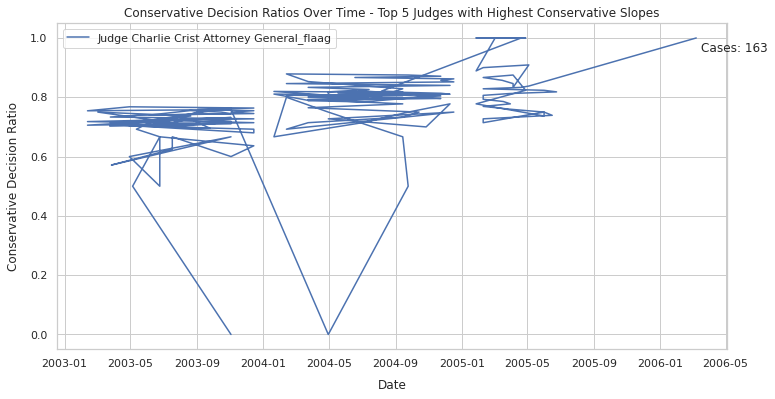

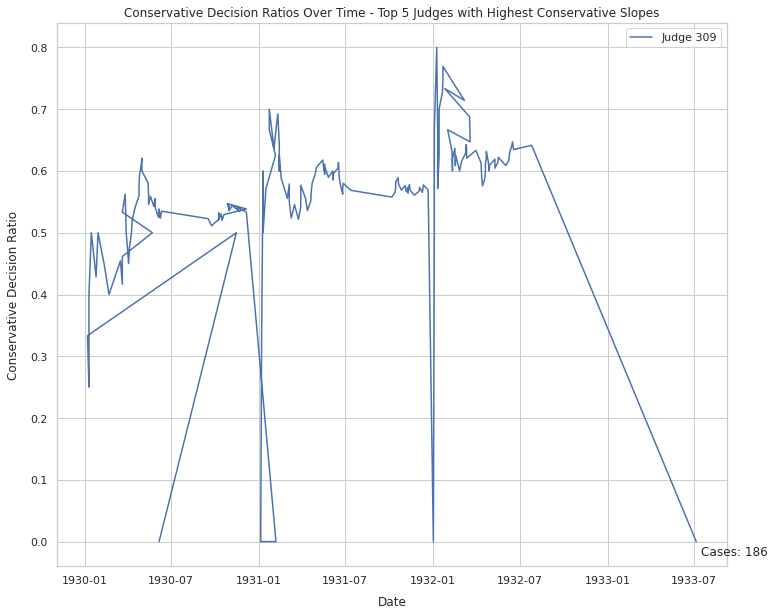

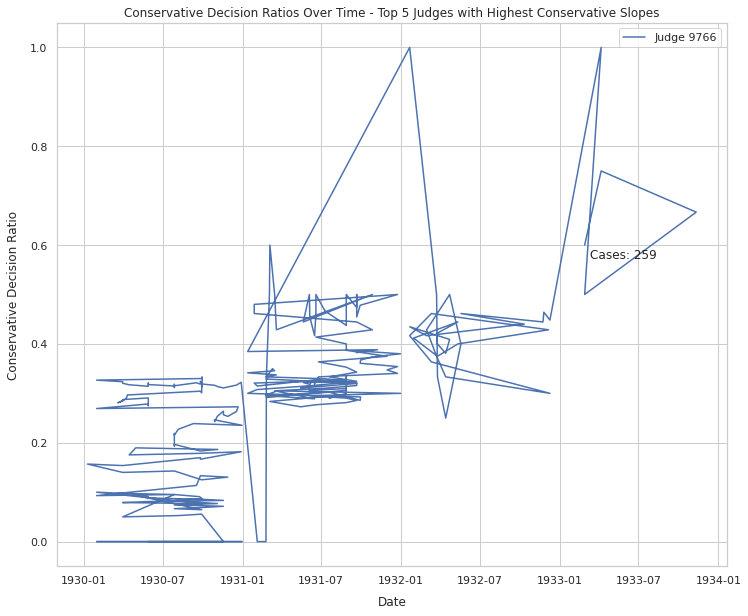

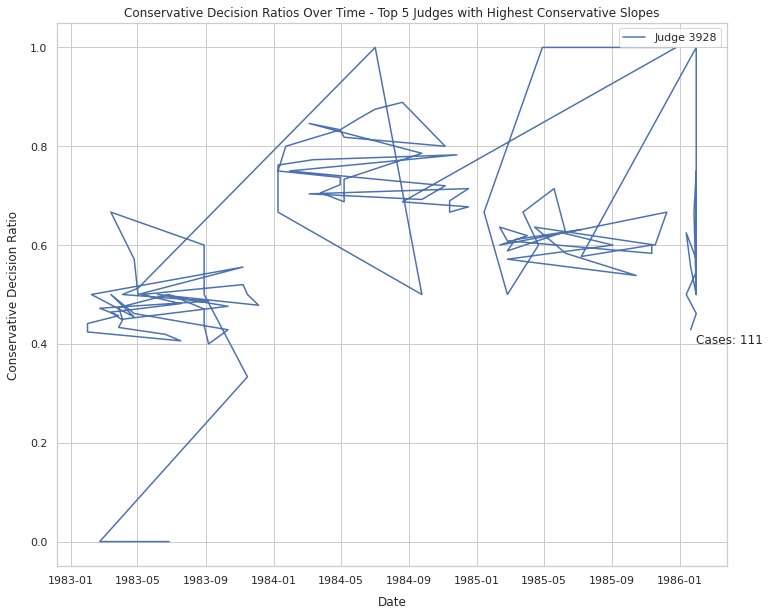

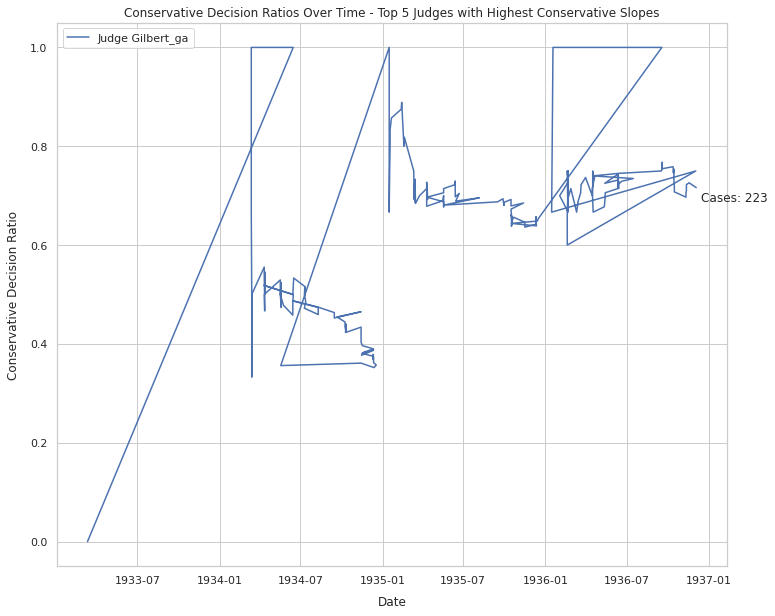

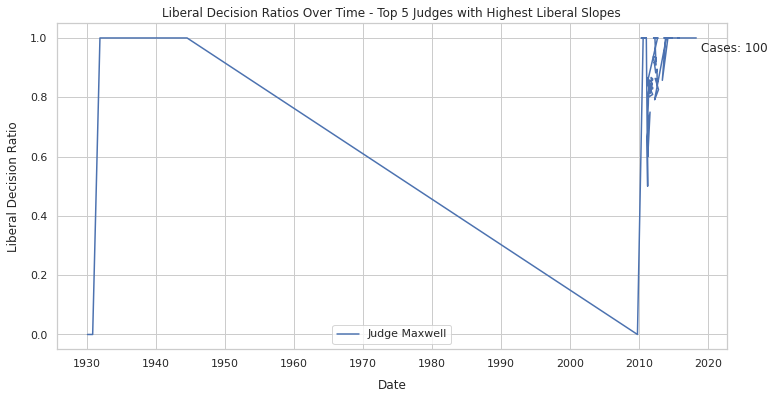

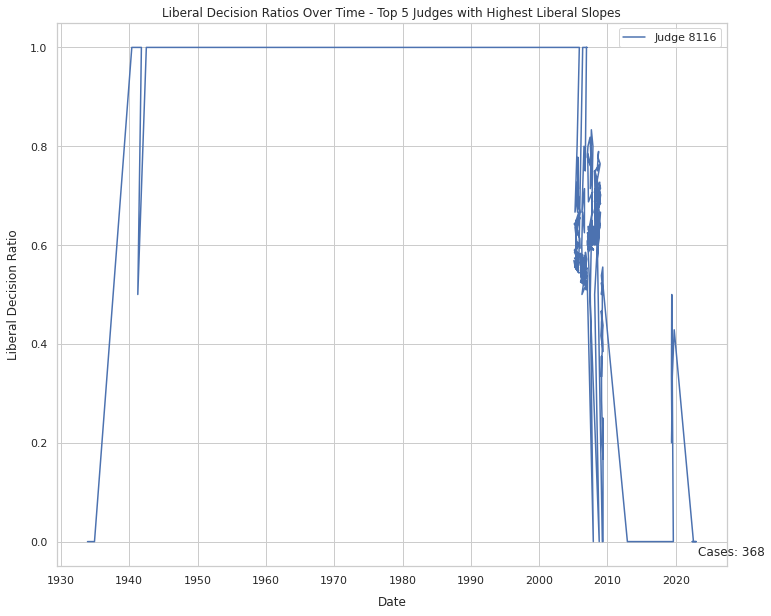

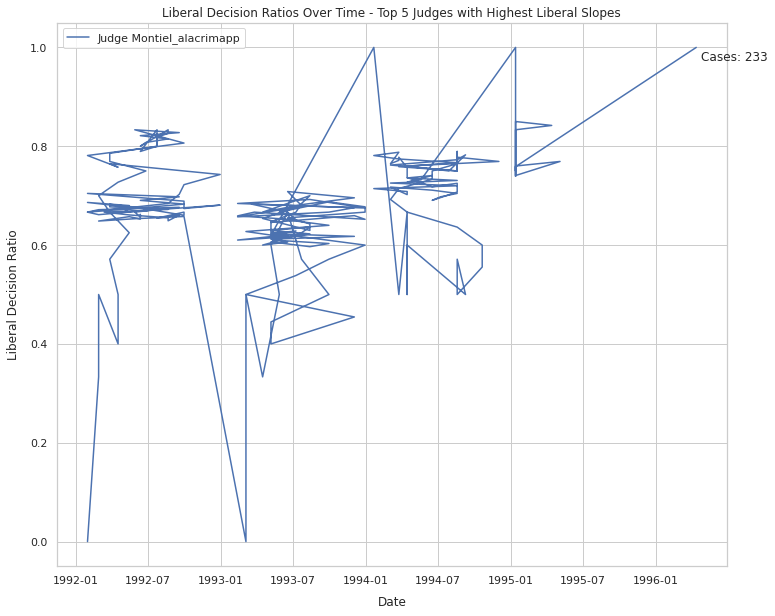

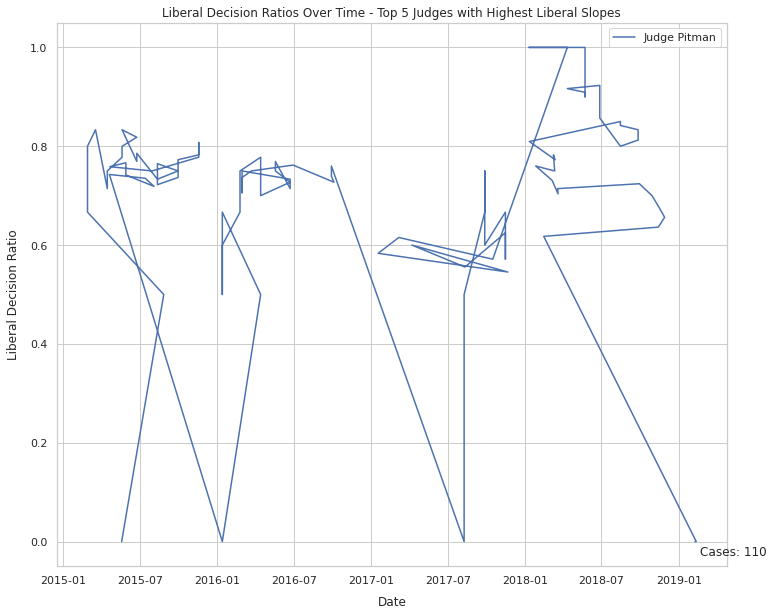

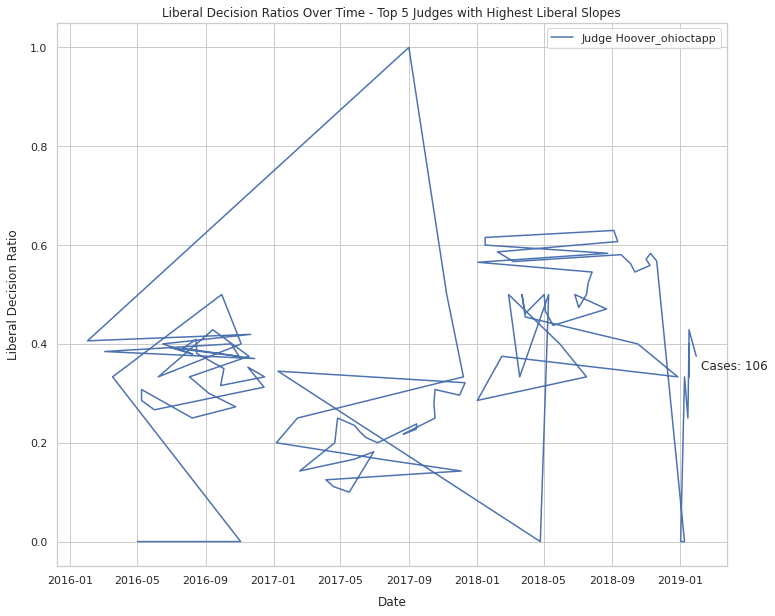

In [49]:
import matplotlib.pyplot as plt

top_5_conservative_judges = judge_slopes_df.sort_values('slope_conservative', ascending = False).head(5)
top_5_liberal_judges = judge_slopes_df.sort_values('slope_liberal', ascending = False).head(5)


# Plot top 5 judges with the highest slope_conservative
plt.figure(figsize=(12, 6))
for judge_id in top_5_conservative_judges['judge_id']:
    judge_data = visualization_df[visualization_df['unique_person_id'] == judge_id]
    plt.plot(judge_data['date_filed'], judge_data['conservative_decision_ratio'], label=f'Judge {judge_id}')
    
    # Annotate with the number of cases
    plt.annotate(f'Cases: {len(judge_data)}', xy=(judge_data['date_filed'].iloc[-1], judge_data['conservative_decision_ratio'].iloc[-1]),
                 xytext=(5, -10), textcoords='offset points', ha='left', va='center')

    plt.title('Conservative Decision Ratios Over Time - Top 5 Judges with Highest Conservative Slopes')
    plt.xlabel('Date')
    plt.ylabel('Conservative Decision Ratio')
    plt.legend()
    plt.show()

# Plot top 5 judges with the highest slope_liberal
plt.figure(figsize=(12, 6))
for judge_id in top_5_liberal_judges['judge_id']:
    judge_data = visualization_df[visualization_df['unique_person_id'] == judge_id]
    plt.plot(judge_data['date_filed'], judge_data['liberal_decision_ratio'], label=f'Judge {judge_id}')
    
    # Annotate with the number of cases
    plt.annotate(f'Cases: {len(judge_data)}', xy=(judge_data['date_filed'].iloc[-1], judge_data['liberal_decision_ratio'].iloc[-1]),
                 xytext=(5, -10), textcoords='offset points', ha='left', va='center')

    plt.title('Liberal Decision Ratios Over Time - Top 5 Judges with Highest Liberal Slopes')
    plt.xlabel('Date')
    plt.ylabel('Liberal Decision Ratio')
    plt.legend()
    plt.show()


In [45]:
# # Ensure that the 'date_filed' column is in datetime format
# president_visualization_df['date_filed'] = pd.to_datetime(president_visualization_df['date_filed'])

# # Calculate the proportion of liberal decisions for each judge at each point in time
# president_visualization_df['liberal_decision_ratio'] = president_visualization_df.groupby(['unique_person_id', 'year_filed'])['decision_direction'].transform(lambda x: x.eq(0).cumsum() / x.notna().cumsum())

# # Iterate over presidents and plot liberal percentage over time with error bars
# for president, data in president_visualization_df.groupby('imputed_president_id'):
#     president_info = president_df[president_df['president_id'] == president].iloc[0]
#     president_name = president_info['president_name']
#     date_start = president_info['year_start']
#     date_termination = president_info['year_termination']
#     partisanship = president_info['partisanship']
    
#     # Filter data for the president's term
#     data = data[data['year_filed'] >= date_start]
    
#     # Calculate the average liberal ratio for the current president
#     avg_liberal_ratio = data['liberal_decision_ratio'].mean()
    
#     plt.figure(figsize=(12, 6))
#     sns.lineplot(x='year_filed', y='liberal_decision_ratio', hue=partisanship, data=data, errorbar='se', palette={0: 'blue', 1: 'red'})  # 'sd' for standard deviation as error bars
    
#     # Add vertical lines for president start and end dates
#     # plt.axvline(x=date_start, color='r', linestyle='--', label='Start Date')
#     plt.axvline(x=date_termination, color='black', linestyle='--', label='Term End Year')
    
#     plt.title(f'Liberal Percentage Over Time - President {president_name}\nAverage Liberal Ratio: {avg_liberal_ratio:.2f}')
#     plt.xlabel('Date')
#     plt.ylabel('Liberal Decision Ratio')
#     plt.legend()  # Show legend for vertical lines
    
#     # Set x-axis limits
#     plt.xlim(date_start, max(data['year_filed']))
    
#     # Set y-axis limits to be the same for all plots
#     plt.ylim(0, 1)
    
#     plt.show()


In [46]:
# # Ensure that the 'date_filed' column is in datetime format
# president_visualization_df['date_filed'] = pd.to_datetime(president_visualization_df['date_filed'])

# # Calculate the proportion of liberal decisions for each judge at each point in time
# president_visualization_df['liberal_decision_ratio'] = president_visualization_df.groupby(['unique_person_id', 'year_filed'])['decision_direction'].transform(lambda x: x.eq(0).cumsum() / x.notna().cumsum())

# # Iterate over presidents and plot liberal percentage over time with error bars
# for president, data in president_visualization_df.groupby('imputed_president_id'):
#     president_info = president_df[president_df['president_id'] == president].iloc[0]
#     president_name = president_info['president_name']
#     date_start = president_info['year_start']
#     date_termination = president_info['year_termination']
#     partisanship = president_info['partisanship']
    
#     # Filter data for the president's term
#     data = data[data['year_filed'] >= date_start]
    
#     # Calculate the average liberal ratio for the current president
#     avg_liberal_ratio = data['liberal_decision_ratio'].mean()
    
#     plt.figure(figsize=(12, 6))
#     sns.lineplot(x='year_filed', y='liberal_decision_ratio', hue=partisanship, data=data, errorbar='se', palette={0: 'blue', 1: 'red'})  # 'sd' for standard deviation as error bars
    
#     # Add vertical lines for president start and end dates
#     # plt.axvline(x=date_start, color='r', linestyle='--', label='Start Date')
#     plt.axvline(x=date_termination, color='black', linestyle='--', label='Term End Year')
    
#     plt.title(f'Liberal Percentage Over Time - President {president_name}\nAverage Liberal Ratio: {avg_liberal_ratio:.2f}')
#     plt.xlabel('Date')
#     plt.ylabel('Liberal Decision Ratio')
#     plt.legend()  # Show legend for vertical lines
    
#     # Set x-axis limits
#     plt.xlim(date_start, max(data['year_filed']))
    
#     # Set y-axis limits to be the same for all plots
#     plt.ylim(0, 1)
    
#     plt.show()


In [47]:
# # Ensure that the 'date_filed' column is in datetime format
# president_visualization_df['date_filed'] = pd.to_datetime(president_visualization_df['date_filed'])

# # Calculate the proportion of liberal decisions for each judge at each point in time
# president_visualization_df['liberal_decision_ratio'] = president_visualization_df.groupby(['unique_person_id', 'year_filed'])['decision_direction'].transform(lambda x: x.eq(0).cumsum() / x.notna().cumsum())

# sns.set(style="whitegrid", font_scale=1.5, context="notebook")

# # Iterate over presidents and plot liberal percentage over time with error bars
# for president, data in president_visualization_df.groupby('imputed_president_id'):
#     president_info = president_df[president_df['president_id'] == president].iloc[0]
#     president_name = president_info['president_name']
#     date_start = president_info['year_start']
#     date_termination = president_info['year_termination']
#     partisanship = president_info['partisanship']
    
#     # Filter data for the president's term
#     data = data[data['year_filed'] >= date_start]
    
#     # Calculate the average liberal ratio for the current president
#     avg_liberal_ratio = data['liberal_decision_ratio'].mean()
    
#     plt.figure(figsize=(12, 6))

#     # Create a twin Axes sharing the xaxis for the count of judges
#     ax1 = plt.gca()
#     ax2 = ax1.twinx()

#     sns.lineplot(x='year_filed', y='liberal_decision_ratio', hue=partisanship, data=data, errorbar='se', palette={0: 'blue', 1: 'red'}, ax=ax1)  # 'sd' for standard deviation as error bars
    
#     # Add vertical lines for president start and end dates
#     ax1.axvline(x=date_termination, color='black', linestyle='--', label='Term End Year')
    
#     # Plot the count of judges per year on the secondary y-axis
#     sns.lineplot(x='year_filed', y='unique_person_id', data=data.groupby('year_filed')['unique_person_id'].nunique().reset_index(), color='grey', ax=ax2)
    
#     ax1.set_title(f'Liberal Percentage Over Time - President {president_name}\nAverage Liberal Ratio: {avg_liberal_ratio:.2f}')
#     ax1.set_xlabel('Date')
#     ax1.set_ylabel('Liberal Decision Ratio')
    
#     ax2.set_ylabel(f'Count of Judges', color='grey')
#     ax2.tick_params('y', colors='grey')
    
#     ax1.legend(loc='upper left')  # Show legend for liberal decision ratio
#     ax1.set_xlim(date_start, max(data['year_filed']))
#     ax1.set_ylim(0, 1)
#     ax1.grid(False)

#     plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# # Assuming president_visualization_df and president_df are already defined

# # Ensure that the 'date_filed' column is in datetime format
# president_visualization_df['date_filed'] = pd.to_datetime(president_visualization_df['date_filed'])

# # Calculate the proportion of liberal decisions for each judge at each point in time
# president_visualization_df['liberal_decision_ratio'] = president_visualization_df.groupby(['unique_person_id', 'year_filed'])['decision_direction'].transform(lambda x: x.eq(0).cumsum() / x.notna().cumsum())

# # Set up the plot
# fig, ax1 = plt.subplots(figsize=(12, 8))

# # Iterate over presidents and plot liberal percentage over time with error bars
# for president, data in president_visualization_df.groupby('imputed_president_id'):
#     president_info = president_df[president_df['president_id'] == president].iloc[0]
#     president_name = president_info['president_name']
#     date_start = president_info['year_start']
#     date_termination = president_info['year_termination']
#     partisanship = president_info['partisanship']
    
#     # Filter data for the president's term
#     data = data[data['year_filed'] >= date_start]
    
#     # Calculate the average liberal ratio for the current president
#     avg_liberal_ratio = data['liberal_decision_ratio'].mean()
    
#     # Plot liberal percentage over time with error bars
#     sns.lineplot(x='year_filed', y='liberal_decision_ratio', hue=partisanship, data=data, ci='sd', palette={0: 'blue', 1: 'red'}, ax=ax1)  # 'sd' for standard deviation as error bars
    
#     # Add vertical lines for president start and end dates
#     ax1.axvline(x=date_termination, color='black', linestyle='--', label='Term End Year')
    
#     ax1.set_title('Liberal Percentage Over Time - All Presidents', fontsize=16)
#     ax1.set_xlabel('Date', fontsize=14)
#     ax1.set_ylabel('Liberal Decision Ratio', fontsize=14)
    
#     ax1.legend(loc='upper left')  # Show legend for liberal decision ratio
#     ax1.set_xlim(president_visualization_df['year_filed'].min(), president_visualization_df['year_filed'].max())
#     ax1.set_ylim(0, 1)

# plt.show()
